<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GCECDL1/fft_western_gcce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiscale Permutation Entropy using feature relevance analysis for vibration-based condition monitoring

## Case Western Reserve Experiments

Database link: https://engineering.case.edu/bearingdatacenter

Vibration signals were collected according to the following conditions (classes): i) Normal bearing (Nor), fault in the internal train (IR1), fault in the external train (IR2), and fault in the rolling element-ball (BE). Moreover, the failure states were produced with three levels of severity (0.007′′, 0.014′′, and 0.021′′) and three operating speeds (1730, 1750, 1772, and 1797 [rpm]). Each experiment was repeated three times, and the data was collected at 12 kHz for 5 seconds. Each signal was divided into ten sub-signals. 

Accordingly, $F_s=12k$ [Hz], $N = 1200$, $T = 4096$, $C = 10$.

In [1]:
!git clone https://github.com/Jectrianama/GCCE_TEST.git

Cloning into 'GCCE_TEST'...
remote: Enumerating objects: 667, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 667 (delta 145), reused 216 (delta 122), pack-reused 407
Receiving objects: 100% (667/667), 30.26 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [2]:
import os
os.chdir('/content/GCCE_TEST/Models')
from  keras_ma_gcce import *
from labels_generation import MA_Clas_Gen

# Loading Data

In [3]:
#data downloaded for google drive
FILEID = "1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O datos.zip && rm -rf /tmp/cookies.txt
!unzip -o datos.zip
!dir
database = 'Western'

--2023-02-11 04:26:51--  https://docs.google.com/uc?export=download&confirm=t&id=1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn
Resolving docs.google.com (docs.google.com)... 209.85.200.138, 209.85.200.113, 209.85.200.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jum5fqu5e4ivgd2f1d2gjjohge7eapv9/1676089575000/09173029842254050324/*/1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn?e=download&uuid=2518ba7e-7d0b-454e-ad38-ee769322aa53 [following]
--2023-02-11 04:26:51--  https://doc-10-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jum5fqu5e4ivgd2f1d2gjjohge7eapv9/1676089575000/09173029842254050324/*/1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn?e=download&uuid=2518ba7e-7d0b-454e-ad38-ee769322aa53
Resolving doc-10-0s-docs.googleusercontent.com (doc-10-0s-docs.googleusercontent.com)... 172.253.114.132,

In [4]:
#main libraries and functions
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import warnings
#compute centroid index 
from sklearn.metrics import pairwise_distances
import matplotlib

warnings.filterwarnings('ignore')


def centroid_(X):
  mean_X = X.mean(axis=0)#computing mean along samples
  D = pairwise_distances(mean_X.reshape(1,-1),X)
  return np.argmin(D)#return centroid index


#loading data
path_ = 'CaractCE.mat'#Case Western Database
dicX = sio.loadmat(path_)

In [5]:
dicX.keys()


dict_keys(['__header__', '__version__', '__globals__', 'CE', 'E', 'F'])

In [6]:
Xt = dicX['F'] #time segments
Fs = 12000 #sampling frequency
Tl = Xt.shape[1]/Fs
print('Xt shape:',Xt.shape)
print('Time length [s]', Tl)

Xt shape: (1200, 4000)
Time length [s] 0.3333333333333333


Multiscale permutation entropy was calculated for each time segment, fixing the delay within [xx,xx] and the embedding time within the range [xx,xxx]. See MPEVA.py for details.

## Loading MPE features, time segments, and labels

In [7]:
#loading precalculated MPE features
X = dicX['CE']
print('MPE feature matriz shape:',X.shape)

MPE feature matriz shape: (1200, 125)


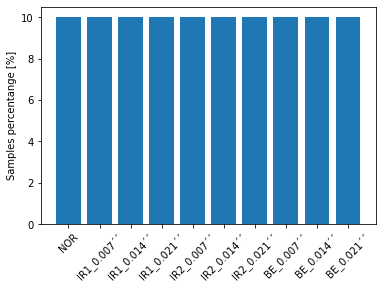

In [8]:
Y = dicX['E']
Ytrue = Y[:,2] #target classes

labels_ = ['NOR','IR1_0.007´´','IR1_0.014´´','IR1_0.021´´',
           'IR2_0.007´´','IR2_0.014´´','IR2_0.021´´',
           'BE_0.007´´','BE_0.014´´','BE_0.021´´'
           ] #classes name

#histogram
unique_elements, counts_elements = np.unique(Ytrue, return_counts=True)
plt.bar(unique_elements,100*counts_elements/X.shape[0])
plt.xticks(unique_elements)
plt.ylabel('Samples percentange [%]')
plt.gca().set_xticklabels(labels_,rotation=45)
plt.show()

In [9]:
#rpm labels
nrpm = 30
Yrpm_b = np.r_[0*np.ones(nrpm),np.ones(nrpm),2*np.ones(nrpm),3*np.ones(nrpm)]
Yrpm_b.shape
Yrpm = Yrpm_b
for i in range(len(labels_)-1):
  Yrpm = np.r_[Yrpm,Yrpm_b]



In [10]:
Y = np.c_[Y,Yrpm]

In [11]:
import joblib

CaseWestern_data = {'Xdata_time' : Xt, 'Fs' : Fs,
                    'Xdata_MPE' : X, 'Y_labels' : Y}

joblib.dump(CaseWestern_data,"CasaWestern_data.pkl")

['CasaWestern_data.pkl']

In [12]:
Y.shape

(1200, 4)

In [13]:
Y

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ...,
       [ 1.,  3., 10.,  3.],
       [ 1.,  3., 10.,  3.],
       [ 1.,  3., 10.,  3.]])

# Interpretability results

In [14]:
Xt.shape

(1200, 4000)

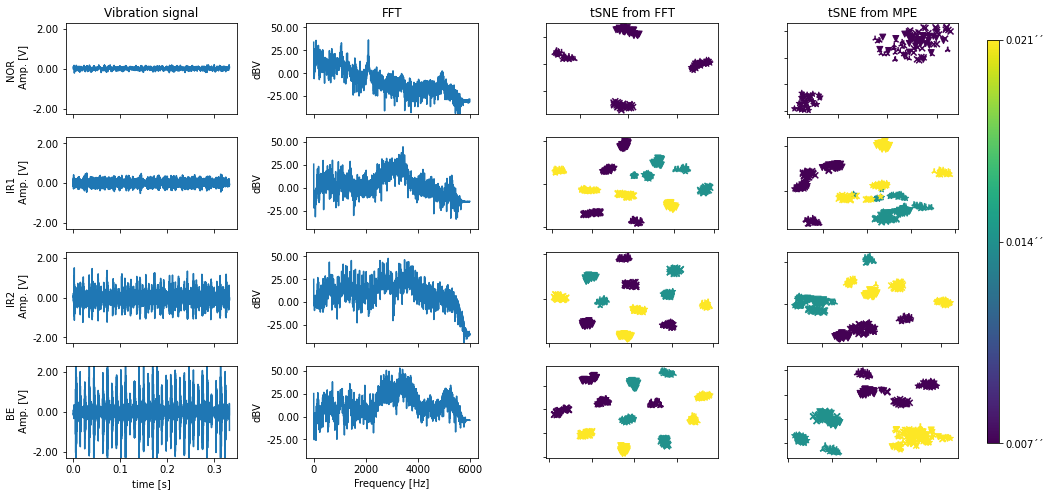

In [15]:
#scatter plots
scar = StandardScaler()
sca = MinMaxScaler()
red = TSNE(perplexity = 10,n_components=2,random_state=123)
vt = np.arange(0,Tl,1/Fs)
Ytrue_f = Y[:,1] # labels = [Normal, Internal, External, Ball]
labels_f = ['NOR', 'IR1', 'IR2', 'BE']
#scatter along fault lables
fig, axs = plt.subplots(len(labels_f),4,figsize=(16, 8))
j=0
vf = np.fft.rfftfreq(Xt.shape[1],1/Fs) #freq vector
Xw = 20*np.log10(abs(np.fft.rfft(Xt))) # FFT

marker_s = ['2','v','x','*'] # RPM1, RPM2, RPM3, RPM4 as marker changes

for i in np.unique(Ytrue_f):
  X_ = Xt[Ytrue_f==i]
  Xw_ = Xw[Ytrue_f==i]
  XE_ = X[Ytrue_f==i]
  Z_ = scar.fit_transform(red.fit_transform(sca.fit_transform(Xw_)))
  Z_e = scar.fit_transform(red.fit_transform(sca.fit_transform(XE_)))
   
  #identify centroid RPM1 
  ind = centroid_(Z_[Yrpm[Ytrue_f==i] == 0])
  #time plots
  axs[j,0].plot(vt,X_[ind])
  axs[j,0].set_ylim([-2.3,2.3])
  axs[j,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[j,0].set_ylabel(labels_f[j]+' \n Amp. [V]')
  if j!=len(labels_f)-1: axs[j,0].set_xticklabels([])

  #frequency plots
  axs[j,1].plot(vf,Xw_[ind])
  axs[j,1].set_ylim([-45,55])
  axs[j,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[j,1].set_ylabel('dBV')
  if j!=len(labels_f)-1: axs[j,1].set_xticklabels([])

  #scatter plots
  cc = Ytrue[Ytrue_f==i]
  #FFT-based features scatter plot
  for ii in np.unique(Yrpm): 
      ind_ = Yrpm[Ytrue_f==i] == ii
      im = axs[j,2].scatter(Z_[ind_,0],Z_[ind_,1],c=cc[ind_],marker=marker_s[int(ii)])
      #axs[j,2].scatter(Z_[ind,0],Z_[ind,1],c='r',marker='v')
      axs[j,2].set_xticklabels([])
      axs[j,2].set_yticklabels([])

      #MPE-based features scatter plot
      im = axs[j,3].scatter(Z_e[ind_,0],Z_e[ind_,1],c=cc[ind_],marker=marker_s[int(ii)])
      #axs[j,3].scatter(Z_e[ind,0],Z_e[ind,1],c='r',marker='v')
      axs[j,3].set_xticklabels([])
      axs[j,3].set_yticklabels([])
  j+=1

cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,cax=cax,ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['0.007´´', '0.014´´', '0.021´´'])

axs[-1,0].set_xlabel('time [s]')
axs[-1,1].set_xlabel('Frequency [Hz]')  
axs[0,0].set_title('Vibration signal')
axs[0,1].set_title('FFT')
axs[0,2].set_title('tSNE from FFT')
axs[0,3].set_title('tSNE from MPE')


fig.subplots_adjust(wspace=0.4, hspace=0.25)
plt.show()



In [16]:
#X.shape

In [17]:
Ytrue.min()
#X = Xw


1

In [18]:
X.shape

(1200, 125)

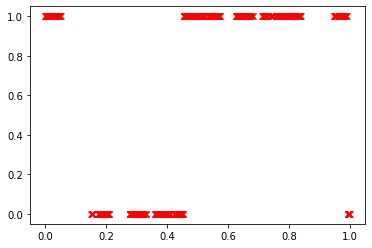

In [19]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,Ytrue, R=5, NrP=1)

In [20]:
Y = Y - 1
t = Ytrue- 1

annotator 1
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       120
           1       0.86      1.00      0.93       120
           2       0.88      0.98      0.93       120
           3       0.85      1.00      0.92       120
           4       0.85      1.00      0.92       120
           5       0.79      0.25      0.38       120
           6       0.84      1.00      0.91       120
           7       0.85      1.00      0.92       120
           8       0.78      0.27      0.40       120
           9       0.89      1.00      0.94       120

    accuracy                           0.85      1200
   macro avg       0.84      0.85      0.81      1200
weighted avg       0.84      0.85      0.81      1200

annotator 2
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       120
           1       0.00      0.00      0.00       120
           2       0.12      0.05      0.07       120


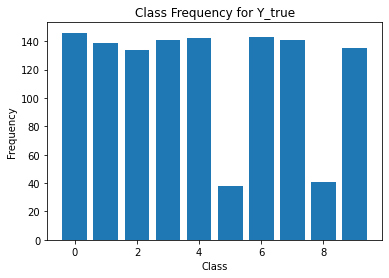

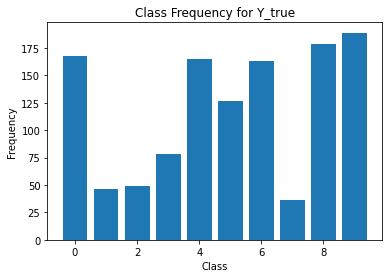

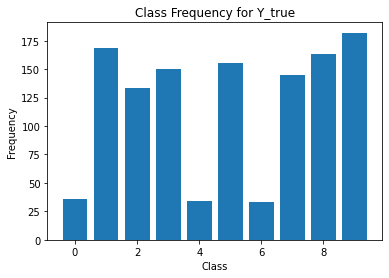

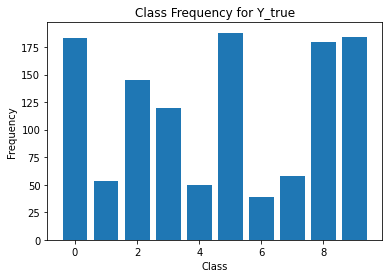

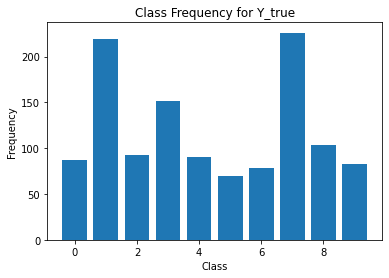

In [21]:
import pandas as pd
from sklearn.metrics import classification_report
for i in range(Y.shape[1]):
    print('annotator',i+1)
    print(classification_report(t,Y[:,i]))
    unique, counts = np.unique(Y[:,i], return_counts=True)
    plt.figure()
    plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[5], return_counts=True)
#     plt.bar(unique, counts)

    plt.title('Class Frequency for Y_true')
    plt.xlabel('Class')
    plt.ylabel('Frequency')


In [22]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[ 156  920  971  897   35  599  567  553  891 1010  524  440 1141  579
  138  566 1186  172  961  610  662  186  134  418  427  245  571  226
  348 1071  637  203 1136  210  701  879  314  448 1088  406  375 1011
  972  694  167  654 1069  678  982 1026  591 1195 1105  690  528  800
  987  568  935   42  476  693  758  486   97  299  746  305    5  490
  336  310  600  968  511  565   72  587  702  656   18   13  774  807
  960  895  802 1117 1044  279  664   67  512  921  136 1157  150 1085
   69  923  384 1106  964  456  825  204  318  196  362  887  417   85
 1051  278  209  499 1019  154  779  844  351  739   98  560  462   86
   45  590  304  228  898  332  103  882  688  429  178  319 1043  822
 1182  294  188  943  229 1114   68  177  621  677 1123  507  376 1007
  787  810  141  756 1033  163  120  240  976  252   95  529  352  431
  617  309  437  870  161  902  772  627  681  266  861  206  909  725
  221 1130 1116 1148  801  768  948  580  754  805 1119  373  973  594
  839 

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

iteration: 0


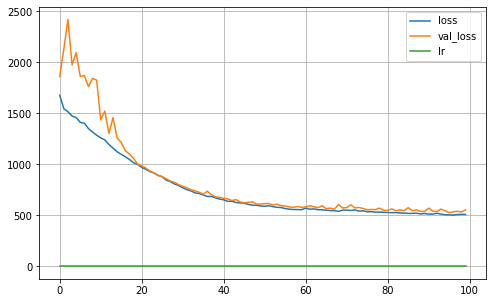

12/12 [==============================] - 0s 14ms/step
Validation ACC: 0.9722
Validation Balanced_ACC: 0.9630
Validation MI: 2.2094
Validation Normalized MI: 0.9667
Validation Adjusted MI: 0.9649
Validation aUc: 1.0000
iteration: 1


KeyboardInterrupt: ignored

In [24]:
from sklearn.metrics import classification_report, balanced_accuracy_score,  roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.01
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.01)

    MA.fit(X_train, Y_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2[:,Y.shape[1]:].argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    print("Validation ACC: %.4f" % (float(ACC[i])))


    # balanced. Accurcy
    BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

    #MI
    
    MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2[:,Y.shape[1]:].argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


    #AUC
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
   # val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, pred_2[:,Y.shape[1]:].argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

In [ ]:
# from sklearn.metrics import classification_report

# l1 =0.01
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.01,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.01)

#     MA.fit(X_train, Y_train)
#     #MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2[:,Y.shape[1]:].argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
#     val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    
  

In [ ]:

ACC

In [ ]:

AUC

In [ ]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)

In [ ]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

In [ ]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

In [ ]:
import pickle

# create the dictionary with 6 scalar variables
Metrics = {
    'Accuracy': np.round( ACC.mean(),4)*100,
    'Accuracy_std': np.round(np.std( ACC),4)*100,
    'AUC': np.round( AUC.mean(),4)*100,
    'AUC_std': np.round(np.std( AUC),4)*100,
    'Balanced Accuracy': np.round( BACC.mean(),4)*100,
    'Balanced Accuracy_std':  np.round(np.std(BACC),4)*100,
    'MI': np.round( MI.mean(),4)*100,
    'MI_std': np.round(np.std(MI),4)*100,
    'Normalized MI': np.round( NMI.mean(),4)*100,
    'Normalized MI_std': np.round(np.std(NMI),4)*100,
    'Adjusted MI': np.round( AMI.mean(),4)*100,
    'Adjusted MI_std': np.round(np.std(NMI),4)*100,
}

# save the dictionary to a file using pickle
with open('data.pickle', 'wb') as handle:
    pickle.dump(Metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)